In [ ]:
#기본 적재
import pandas as pd

In [ ]:
#머신러닝에 필요한 기본 패키지 설치
!pip install geopandas
!pip install scipy
!pip install matplotlib
!pip install ipython
!pip install scikit-learn
!pip install pillow
!pip install wrapt
!pip install tensorflow==2.0.0
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 47.8 MB/s 
     |████████████████████████████████| 6.3 MB 35.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab

In [ ]:
#머신러닝 데이터 적재
from os import listdir
from os.path import isfile, join
import pandas as pd
import geopandas as gpd
import time
import json
import folium
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
import fiona
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt

from tqdm import trange, tqdm, tqdm_notebook, tnrange

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import Binarizer, MinMaxScaler
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [ ]:
#고양시 250
df_고양시250 = pd.read_csv('/content/250격자 고양시(0값 제거).csv')
df_세종시250 = pd.read_csv('/content/250격자 세종시(0값 제거).csv') 

In [ ]:
#행, 열이름표시
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [ ]:
#train, test 
X_train = df_고양시250.iloc[:, 2:7]
X_test = df_세종시250.iloc[:, 2:7]
y_train = df_고양시250.iloc[:, -1]
y_test = df_세종시250.iloc[:, -1]

In [ ]:
#스케일링
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X_train_scaled = std.transform(X_train)
X_test_scaled = std.transform(X_test)

In [ ]:
#오버샘플링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(X_train_scaled)
X_train = scaler.fit_transform(X_train_scaled)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE(sampling_strategy='auto')

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_resample(X_train_scaled,list(y_train))

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))


After OverSampling, the shape of train_X: (4880, 5)
After OverSampling, the shape of train_y: (4880, 5) 



In [ ]:
#샘플링 된 값 다시 train값으로
X_train = X_resampled
y_train = y_resampled

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print('모델의 정확도 :', dtc.score(X_test, y_test))

모델의 정확도 : 0.469601677148847


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


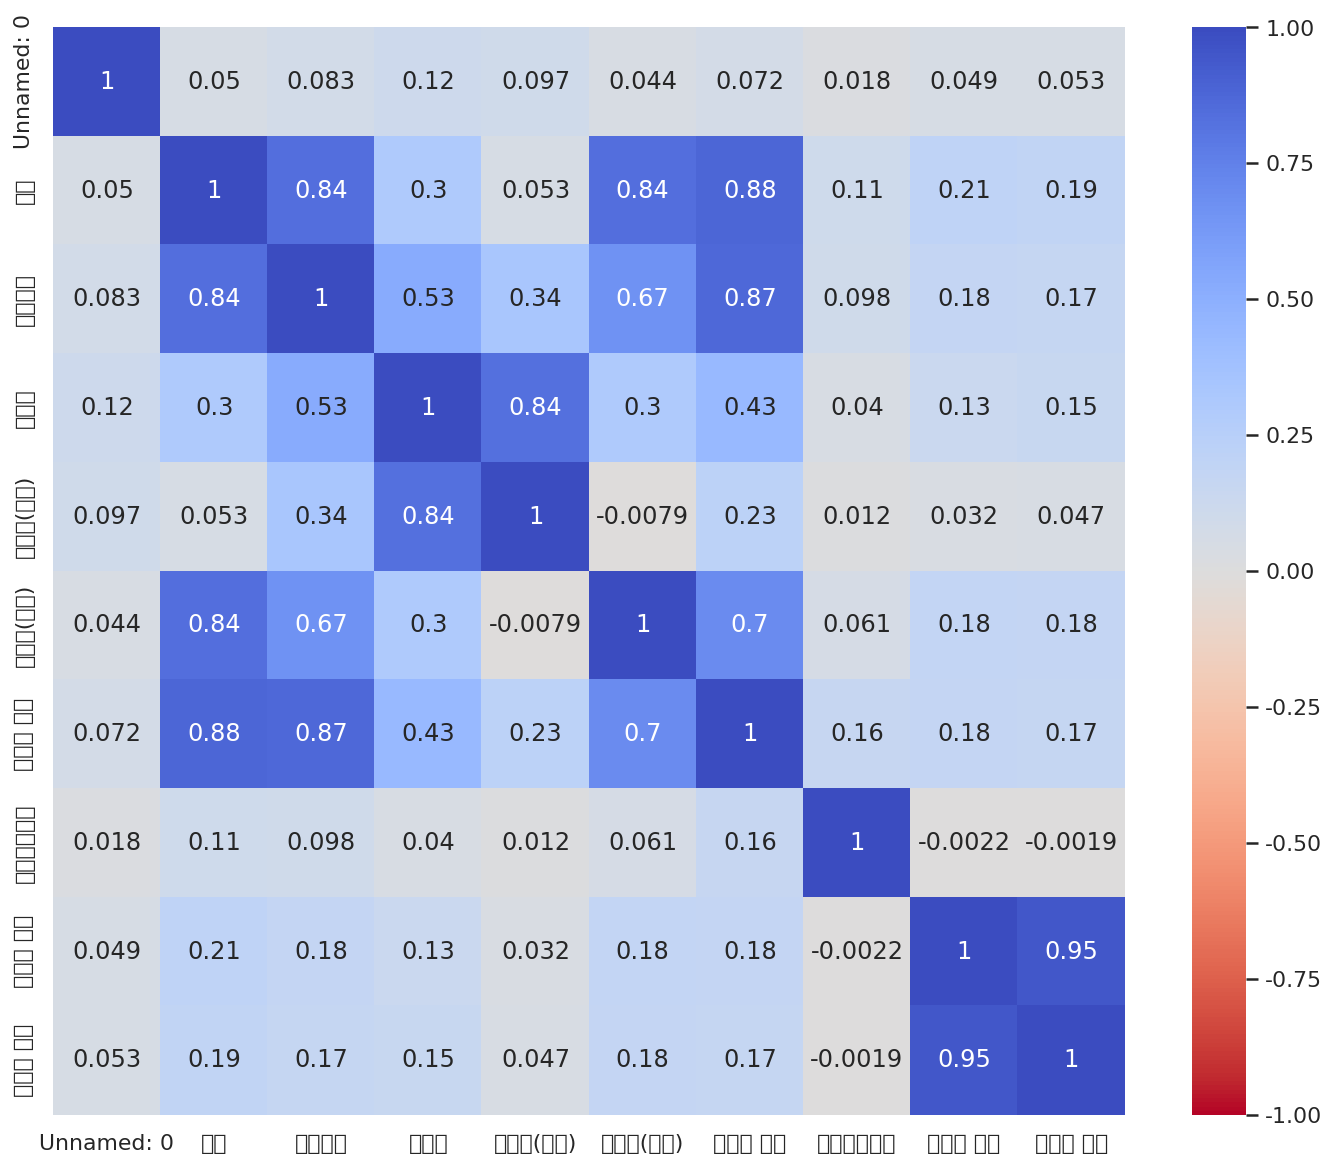

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(df_세종시250.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm_r")
plt.show()

In [ ]:
#나오는 방식 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [ ]:
#Randomforest 결과값
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=22)
rf.fit(X_train, y_train)

print("RF 훈련 세트 정확도: {:.3f}".format(rf.score(X_train, y_train)))
print("RF 테스트 세트 정확도: {:.3f}".format(rf.score(X_test, y_test)))

# 예측
preds_rf = rf.predict(X_test)
pred_proba_rf = rf.predict_proba(X_test)[:,1]  

# 평가
get_clf_eval(y_test, preds_rf, pred_proba_rf)

RF 훈련 세트 정확도: 0.982
RF 테스트 세트 정확도: 0.758
오차 행렬
[[2507  727]
 [  81   24]]
정확도: 0.7580, 정밀도: 0.0320, 재현율: 0.2286, F1: 0.0561, AUC: 0.4911


In [ ]:
#의사결정나무 모형, 배깅 모형 구현
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=22)
bag = BaggingClassifier(base_estimator=tree, n_estimators=400, bootstrap=True, bootstrap_features=False, random_state= 22)


In [ ]:
#의사결정나무 결과값

tree.fit(X_train, y_train)

print("tree 의사결정나무 훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("tree 테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

# 예측
preds_tree = tree.predict(X_test)
pred_proba_tree = tree.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds_tree, pred_proba_tree)

훈련 세트 정확도: 0.982
테스트 세트 정확도: 0.798
오차 행렬
[[2642  592]
 [  81   24]]
정확도: 0.7984, 정밀도: 0.0390, 재현율: 0.2286, F1: 0.0666, AUC: 0.5228


In [ ]:
#배깅 결과값

bag.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(bag.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(bag.score(X_test, y_test)))

# 예측
preds_bag = bag.predict(X_test)
pred_proba_bag = bag.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds_bag, pred_proba_bag)

훈련 세트 정확도: 0.982
테스트 세트 정확도: 0.741
오차 행렬
[[2448  786]
 [  80   25]]
정확도: 0.7406, 정밀도: 0.0308, 재현율: 0.2381, F1: 0.0546, AUC: 0.5280


In [ ]:
#AdaBoost 구현
from sklearn.ensemble import AdaBoostClassifier
abm = AdaBoostClassifier()

abm.fit(X_train, y_train)

AdaBoostClassifier()

In [ ]:
#AdaBoost 결과값

print("Ada 훈련 세트 정확도: {:.3f}".format(abm.score(X_train, y_train)))
print("Ada 테스트 세트 정확도: {:.3f}".format(abm.score(X_test, y_test)))

# 예측
preds_abm = abm.predict(X_test)
pred_proba_abm = abm.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds_abm, pred_proba_abm)

Ada 훈련 세트 정확도: 0.720
Ada 테스트 세트 정확도: 0.614
오차 행렬
[[2024 1210]
 [  80   25]]
정확도: 0.6137, 정밀도: 0.0202, 재현율: 0.2381, F1: 0.0373, AUC: 0.3963


In [ ]:
#XGboost구현
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(X_train, y_train)


[07:58:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
#XGBoost 결과값

print("XG 훈련 세트 정확도: {:.3f}".format(xg.score(X_train, y_train)))
print("XG 테스트 세트 정확도: {:.3f}".format(xg.score(X_test, y_test)))

# 예측
preds_xg = xg.predict(X_test)
pred_proba_xg = xg.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds_xg, pred_proba_xg)

XG 훈련 세트 정확도: 0.480


ValueError: ignored

In [ ]:
# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
# Predict를 수행하고 mean_absolute_error, rmse 결과 출력하기
pred_xg = xg.predict(X_test)
print(mean_absolute_error(y_test, pred_xg))
print(sqrt(mean_squared_error(y_test, pred_xg)))

ValueError: ignored

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
lgbm = LGBMClassifier(n_estimators=4000)
lgbm.fit(X_train, y_train,
                 # 조기 중단 파라미터
                 early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                 verbose=True)

[1]	valid_0's binary_logloss: 0.708757	valid_0's binary_logloss: 0.708757
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.682225	valid_0's binary_logloss: 0.682225
[3]	valid_0's binary_logloss: 0.679059	valid_0's binary_logloss: 0.679059
[4]	valid_0's binary_logloss: 0.645338	valid_0's binary_logloss: 0.645338
[5]	valid_0's binary_logloss: 0.663235	valid_0's binary_logloss: 0.663235
[6]	valid_0's binary_logloss: 0.649629	valid_0's binary_logloss: 0.649629
[7]	valid_0's binary_logloss: 0.653006	valid_0's binary_logloss: 0.653006
[8]	valid_0's binary_logloss: 0.633606	valid_0's binary_logloss: 0.633606
[9]	valid_0's binary_logloss: 0.623761	valid_0's binary_logloss: 0.623761
[10]	valid_0's binary_logloss: 0.600884	valid_0's binary_logloss: 0.600884
[11]	valid_0's binary_logloss: 0.598839	valid_0's binary_logloss: 0.598839
[12]	valid_0's binary_logloss: 0.585111	valid_0's binary_logloss: 0.585111
[13]	valid_0's binary_logloss: 0.578829	valid_

LGBMClassifier(n_estimators=4000)

In [ ]:
#LightBoost 결과값

print("LGBM 훈련 세트 정확도: {:.3f}".format(lgbm.score(X_train, y_train)))
print("LGBM 테스트 세트 정확도: {:.3f}".format(lgbm.score(X_test, y_test)))
# 예측
preds_lgbm = lgbm.predict(X_test)
pred_proba_lgbm = lgbm.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds_lgbm, pred_proba_lgbm)

LGBM 훈련 세트 정확도: 0.919
LGBM 테스트 세트 정확도: 0.754
오차 행렬
[[2498  736]
 [  84   21]]
정확도: 0.7544, 정밀도: 0.0277, 재현율: 0.2000, F1: 0.0487, AUC: 0.4965
